In [2]:
from Gao_Algorithm import * 
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
random.seed(30)
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
import GPy
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
import datafold
from datafold.pcfold import PCManifold
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
from sklearn.model_selection import train_test_split

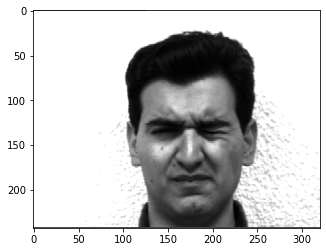

In [2]:
imageformat=".jpg"
path = "C:/Users/anany/Desktop/master_thesis-master/yalefaces/yalefaces/"
imfilelist=[os.path.join(path,f) for f in os.listdir(path) if f.endswith(imageformat)]
imagelist = []
for el in imfilelist:
        image = Image.open(el)
        image=np.array(image)
        imagelist.append(image)
        plt.imshow(image,cmap = 'gray')

In [3]:
imagelist = np.array(imagelist) 
imagelist = imagelist.reshape(imagelist.shape[0], -1)
imagelist = imagelist / 255.0

In [4]:
imagelist.shape

(165, 77760)

In [5]:
y = np.array([int(i / 11) for i in range(imagelist.shape[0])])
y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

In [7]:
n_classes = 15
#y = np.floor(np.arange(data.shape[0])/((1+data.shape[0])/n_classes)).astype(np.int)

print("Classes: ", np.unique(y))
print("Number of points per class:", [np.sum(y==k) for k in np.unique(y)])

random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(imagelist, y, test_size=test_size, random_state=random_state)

# note that y_test and X_test is never used below.

Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of points per class: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [13]:
#####DIVIDING DATASETS INTO BATCHES ##### 

num_lmk_per_batch = 3 # how many landmarks to find per batch
batch_size = 6      # points per batch
n_batches = 2 # number of batches chosen per class

total_landmarks = np.array([])
idx_all = np.arange(X_train.shape[0])

# define a random number generator and use it to draw samples for batching
_rng = np.random.default_rng(random_state)
x = []
x_labels = []
for current_class in np.unique(y_train):
    
    # setup the dataset for the current class
    idx_class = (y_train == current_class)
    X_train_class = X_train[idx_class, :]
    y_train_class = y_train[idx_class]
    total_landmarks_class = np.array([])
    
    print(f"Number of points in class {current_class}: {X_train_class.shape[0]}")
    
    for _ in range(n_batches):
    
        # draw new batch at random
        batch_indices = _rng.choice(X_train_class.shape[0], size=(batch_size,))
        cat_data = X_train_class[batch_indices,:]
        x.append(cat_data)
        x_labels.append(y_train_class[batch_indices])
        # append the previous landmark data points to the array so that we can use them for the next landmarking call
        if len(total_landmarks_class) > 0:
            cat_data = np.row_stack([X_train_class[total_landmarks_class,:], cat_data])
        print(f"cat_data shape: {cat_data.shape[0]}")
        (GPLmkIdx, ptuq) = GetGPLmk_Euclidean(cat_data, num_lmk_per_batch, batch_size, BNN = 4, len(total_landmarks_class))
        # clean up the new indices by removing the ones we know
        GPLmkIdx = GPLmkIdx[len(total_landmarks_class):] - len(total_landmarks_class)
        GPLmkIdx = GPLmkIdx[GPLmkIdx >= 0]
        # add the new indices to the old ones
        unique_new_landmarks = np.unique(batch_indices[GPLmkIdx])
        total_landmarks_class = np.concatenate([total_landmarks_class, unique_new_landmarks]).astype(np.int)
    
    print(f"Found {len(total_landmarks_class)} landmarks for class {current_class}.")
    
    total_landmarks = np.concatenate([total_landmarks, idx_all[idx_class][total_landmarks_class]]).astype(np.int)
    
print(f"Total number of landmarks: {len(total_landmarks)}")
tot_landmarks = np.array(total_landmarks)
tot_landmarks = tot_landmarks.reshape(-1, )
x = np.array(x)
x = x.reshape(15 * n_batches * batch_size, -1)
x_labels = np.array(x_labels)
x_labels = x_labels.reshape(-1, )

Number of points in class 0: 10
cat_data shape: 6
cat_data shape: 9
Found 3 landmarks for class 0.
Number of points in class 1: 6
cat_data shape: 6
cat_data shape: 7
Found 3 landmarks for class 1.
Number of points in class 2: 7
cat_data shape: 6
cat_data shape: 8
Found 4 landmarks for class 2.
Number of points in class 3: 11
cat_data shape: 6
cat_data shape: 9
Found 4 landmarks for class 3.
Number of points in class 4: 10
cat_data shape: 6
cat_data shape: 9
Found 4 landmarks for class 4.
Number of points in class 5: 8
cat_data shape: 6
cat_data shape: 8
Found 4 landmarks for class 5.
Number of points in class 6: 9
cat_data shape: 6
cat_data shape: 8
Found 5 landmarks for class 6.
Number of points in class 7: 9
cat_data shape: 6
cat_data shape: 8
Found 4 landmarks for class 7.
Number of points in class 8: 9
cat_data shape: 6
cat_data shape: 9
Found 4 landmarks for class 8.
Number of points in class 9: 9
cat_data shape: 6
cat_data shape: 9
Found 5 landmarks for class 9.
Number of points 

In [14]:
tempGPLmkIdx = tot_landmarks[:30]
land = X_train[tempGPLmkIdx]
land = land.reshape(land.shape[0], image.shape[0], image.shape[1])
land.shape

(30, 243, 320)

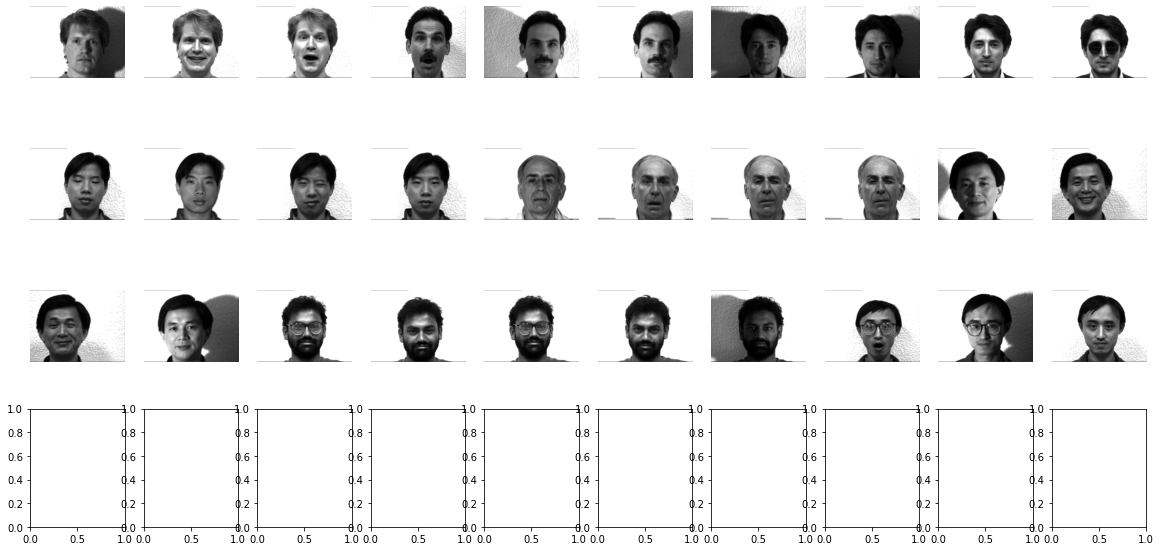

In [15]:
f, axarr = plt.subplots(int(np.ceil(land.shape[0] / 10.0)) + 1, 10,figsize=(20,10))
for i in range(land.shape[0]):
    axarr[int(np.floor(i / 10)), (i % 10)].imshow(land[i], cmap='gray')
    axarr[int(np.floor(i / 10)), (i % 10)].axis('off')

In [16]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(x_labels.reshape(-1, 1))
onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
number_of_classes = 15
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

In [18]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

In [24]:
def landmark_gp_clustering_accuracy(landmarks, landmark_labels, coords, y):
    if(landmarks.shape[0] < 16):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [20]:
np.random.shuffle(tot_landmarks)

In [51]:
def landmark_clustering_accuracy(landmarks, landmarks_labels, coords, y):
    if(landmarks.shape[0] < 2):
        return 0
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmarks_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [52]:
accuracies_knn = [landmark_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  2 Accuracy:  0.030303030303030304
Landmarks:  3 Accuracy:  0.09090909090909091
Landmarks:  4 Accuracy:  0.12121212121212122
Landmarks:  5 Accuracy:  0.24242424242424243
Landmarks:  6 Accuracy:  0.2727272727272727
Landmarks:  7 Accuracy:  0.24242424242424243
Landmarks:  8 Accuracy:  0.21212121212121213
Landmarks:  9 Accuracy:  0.21212121212121213
Landmarks:  10 Accuracy:  0.24242424242424243
Landmarks:  11 Accuracy:  0.24242424242424243
Landmarks:  12 Accuracy:  0.24242424242424243
Landmarks:  13 Accuracy:  0.2727272727272727
Landmarks:  14 Accuracy:  0.36363636363636365
Landmarks:  15 Accuracy:  0.3939393939393939
Landmarks:  16 Accuracy:  0.3939393939393939
Landmarks:  17 Accuracy:  0.3939393939393939
Landmarks:  18 Accuracy:  0.3939393939393939
Landmarks:  19 Accuracy:  0.3939393939393939
Landmarks:  20 Accuracy:  0.48484848484848486
Landmarks:  21 Accuracy:  0.5151515151515151
Landmarks:  22 Accuracy:  0.5151515151515151
Landmarks:  23 Accuracy:  0.5757575757575758
Landm

In [6]:
accuracies_gp = [0,
 0,
 0,
 0.09242424242424243,
 0.09242424242424243,
 0.09242424242424243,
 0.15242424242424243,
 0.19242424242424243,
 0.19242424242424243,
 0.19242424242424243,
 0.20242424242424243,
 0.22242424242424243,
 0.23242424242424243,
 0.2527272727272727,
 0.34363636363636365,
 0.3739393939393939,
 0.3739393939393939,
 0.3739393939393939,
 0.3839393939393939,
 0.3839393939393939,
 0.45484848484848486,
 0.5051515151515151,
 0.5051515151515151,
 0.5557575757575758,
 0.6263636363636364,
 0.676969696969697,
 0.676969696969697,
 0.686969696969697,
 0.7072727272727273,
 0.7072727272727273,
 0.7072727272727273,
 0.7072727272727273,
 0.7072727272727273,
 0.7072727272727273,
 0.7272727272727273,
 0.7272727272727273,
 0.7272727272727273,
 0.7272727272727273,
 0.8687878787878788,
 0.8687878787878788,
 0.8687878787878788,
 0.8781818181818182,
 0.8791818181818182,
 0.8801818181818182,
 0.8917878787878788]

In [7]:
len(accuracies_gp)

45

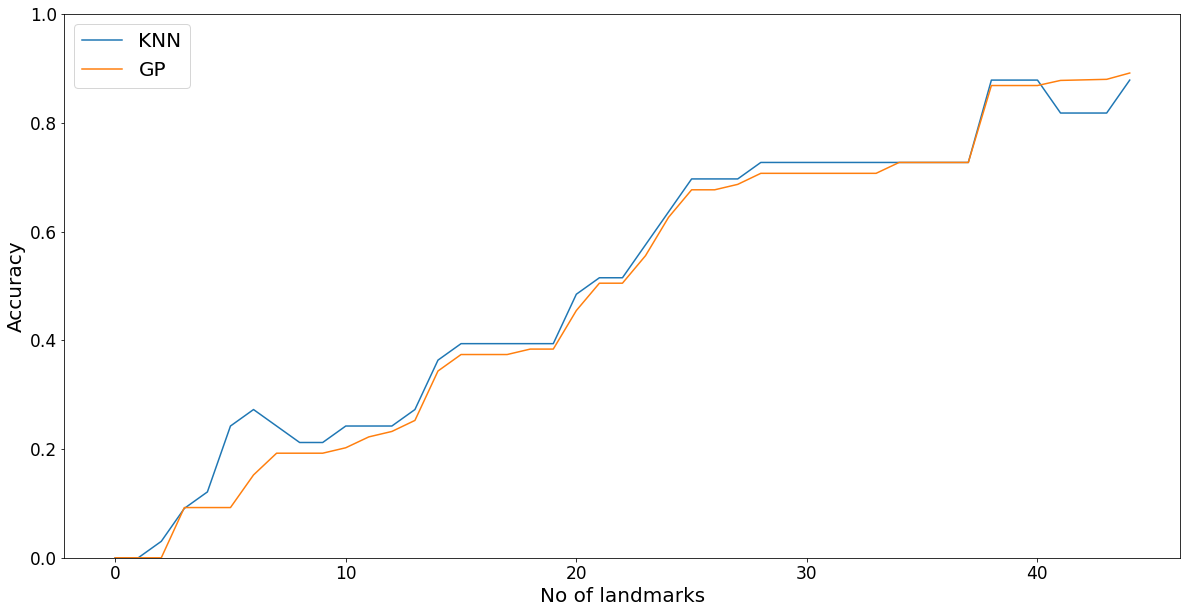

In [8]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, 45, 1), accuracies_knn, label = "KNN")
plt.plot(range(0, 45, 1), accuracies_gp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
#plt.title('Gao algorithm accuracies vs landmarks using KNN and GP' ,fontsize=16)
plt.legend(fontsize=20)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_gao_yales.png')